In [1]:
import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
import h5py

#multiplies 2 matricies
def mat_mul(A, B):
    return tf.matmul(A, B)

#Reads hdf5 files
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

#Applies random rotation angles to random point clouds
def rotate_point_cloud(batch_data):
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval], [0, 1, 0], [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

#adds noice to some random points
def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    B, N, C = batch_data.shape
    print(B , N , C)
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data


Using TensorFlow backend.


In [2]:
#checking for gpu in keras
import keras

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15020959994319902239
]


In [2]:
# number of points in each sample
num_points = 2048

# number of categories
k = 7 # 0 big parallelepipeds, 1 small parallelepipeds , 2 small spheres, 3 big spheres, 4 cubes, 5 cylinders, 6 pyramids

# define optimizer
adam = optimizers.Adam(lr=0.005, decay=0.7)

# Pointnet Architecture

# Input Transformation net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# Forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# Feature Transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# Forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# Global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# Point_net_classification
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)

model = Model(inputs=input_points, outputs=prediction)

W0828 11:45:35.167169 10440 deprecation_wrapper.py:119] From C:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 11:45:35.169088 10440 deprecation_wrapper.py:119] From C:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 11:45:35.176933 10440 deprecation_wrapper.py:119] From C:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 11:45:35.320442 10440 deprecation_wrapper.py:119] From C:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 11:45:35.564258 10440 deprecation_wrapper.py:119] From C:\Anaconda\lib\site-packages\keras\b

In [4]:
#loads the hdf5 files to fit and test the network

# load train points and labels
path = os.path.dirname(os.path.realpath("train_cls.py")) #current path
train_path = os.path.join(path, "Dataset/Train")
filenames = [d for d in os.listdir(train_path)]
print(train_path)
print(filenames)
train_points = None
train_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
        
train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, 1)

# load test points and labels
test_path = os.path.join(path, "Dataset/Test")
filenames = [d for d in os.listdir(test_path)]
print(test_path)
print(filenames)
test_points = None
test_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
        
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, 1)

checkpointer = ModelCheckpoint(filepath=test_path, monitor='val_acc', mode='max', verbose=0, save_best_only=True)

C:\Users\João Ramos\Documents\Jupyter\Tese\Dataset/Train
['file1.h5']
C:\Users\João Ramos\Documents\Jupyter\Tese\Dataset/Test
['file2.h5']
Created


In [6]:
# label to categorical
train_labels_r = train_labels_r -1
test_labels_r = test_labels_r -1
Y_train = np_utils.to_categorical(train_labels_r, k)
Y_test = np_utils.to_categorical(test_labels_r, k)

# compile classification model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


[[-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]]
Categorical


In [5]:
#Loads pre-trained weights
from keras.models import load_model

model.load_weights('classification_weights.h5')
print("Weights loaded !")

Weights loaded !


In [ ]:
# Fit model on training data

for i in range(1,2): #number of epochs to train
    
    # rotate and jitter the points
    train_points_rotate = rotate_point_cloud(train_points_r)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    model.fit(train_points_jitter, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    s = "Current epoch is:" + str(i)
    print(s)
    if i % 2 == 0:
        score = model.evaluate(test_points_r, Y_test, verbose=1)
        print('Test loss: ', score[0])
        print('Test accuracy: ', score[1])


12227 1024 3


W0820 23:49:35.997382  5392 deprecation.py:323] From C:\Anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
  128/12227 [..............................] - ETA: 55:08 - loss: 3.3863 - acc: 0.1484  

In [16]:
# save the trained weights
model.save_weights('classification_weights.h5')
print("Saved weights !")

Saved weights !


2


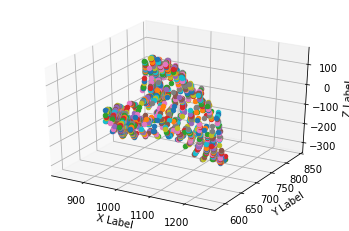

In [33]:
#visualization of the point cloud predicted and its result

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# select one test data to visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
v_points = test_points_r[74:75,:,:] #point cloud selected
pred = model.predict(v_points)
pred = np.squeeze(pred)
v_points = np.squeeze(v_points)
pred = pred.tolist() 

#highest class result
print (pred.index(max(pred)))


for i in range(v_points.shape[0]):  
    xs = v_points[i,0]
    ys = v_points[i,1]
    zs = v_points[i,2]
    ax.scatter(xs, ys, zs)
     

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


In [34]:
import pandas as pd

results = pd.DataFrame(data = pred, columns = ["Percentage"])
results.sort_values( by=['Percentage'], inplace=True, ascending = False)
# 0 parallelepipeds, 1 spheres, 2 cubes, 3 cylinders, 4 pyramids
# prints the 3 most probable classes and their percentage
print (results.head(3))

   Percentage
2    0.343417
3    0.306997
0    0.152657
